# Questions Clustering - English

## Expected
Questions to be sorted out such that the response to the whole cluster is same.

<!--### To Do-->
Author: Sunanda Bansal  
Organization: Dataperformers  
License: CC BY-NC  
Date: 24 Mar, 2020 (Start)  

In [69]:
import re
import regex
import os
import csv
import sys
import json
import time
import scipy
import socket
import pickle
import numpy as np
import pandas as pd
import multiprocessing as mp
from importlib import reload

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Normalizer   
from sklearn import metrics   
from sklearn.metrics import confusion_matrix
# from sklearn.metrics.pairwise import paired_distances as sklearn_paired_distances

# Plotting
import seaborn as sn
import matplotlib.pyplot as plt

# importing personal development helper classes
import utils

In [70]:
pd.__version__

'0.25.3'

## Define variables here

Mostly the code will be intended to use with arguments that can be passed in comman line, but jupyter notebook doesn't handle `argparse` well, so the Args class is a temporary way to write the code assumming the variables to be an attribute of an object.

In [71]:
class Args:
    def __init__(self):
        # The very big scraped file, give absolute path, outside the repo
        # self.filename = "query_result_2020-03-27T19_12_30.866993Z.csv"
        self.filename = "covid_questions_2020-04-21.csv"
        
        # path to the file
        self.dataset = f"data/{self.filename}"    
        
        # suffix used to create
        self.suffix = "_".join([word for word in self.filename.split("_") if not word.isalpha()])[:-4]
        self.vector_mode = "tfidf"
        self.n_topics = 230
        self.dist_thresh = 1.5
        self.lang = "en"
args=Args()

In [72]:
# Disable (FALSE) displaying warnings from the OpenMP* run-time library during program execution.
os.environ['KMP_WARNINGS'] = "FALSE"

## Functions

In [73]:
# Regex functions
def surrounding(word,area=2):
    # A funtion, yet to be defined, that can be used to extract text around keywords
    return  
    
# Language Detection
from langdetect import detect
def detect_lang(text):
    # Used to detect language of the question
    try:
        return detect(text)
    except:
        return "unidentifiable"   

### Natural Lanuage Proprocessing Functions
   
Preprocessing done -
   1. Normalizing accents  
   2. Removing non alphabetic characters  
   3. Casefolding  

Preprocessing not done -
   1. Stopword removal - For questions, stopwords are essential and thus are retained
   2. Stemming - For rule based analysis it might be useful to keep the words as they are, for LSA, the questions don't have enough variation in content to benefit for stemming

In [74]:
import re
import nltk
import unidecode

# Regular expression to select all that is not alphabet
# @maybe allow numbers as well
alpha_regex = re.compile('[^a-zA-Z]')

from nltk.corpus import stopwords as sw
if args.lang == "en": stopwords = sw.words('english')
if args.lang == "fr": stopwords = sw.words('french')

from nltk.stem.snowball import SnowballStemmer
if args.lang == "en": stemmer = SnowballStemmer("english")
if args.lang == "fr": stemmer = SnowballStemmer("french")

def tokenize(text):
    '''
        1. Normalized accents
        2. Splits at non alpbhaetic character (@maybe need to revisit for french text)
        3. Caasefolds
    '''    
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            # Handle french accents in text
            word = unidecode.unidecode(word)
            
            # Split at every non alphabet character occurrence
            clean_words = alpha_regex.sub(' ', word).split()
            
            # Casefold
            tokens.extend([word.lower() for word in clean_words])
    
    # Return tokens
    return tokens

def stem(word):
    return stemmer.stem(word).strip()

def preprocess(text):    
    tokenized = tokenize(text)
    # cleaned = [word for word in tokenized if word not in stopwords and word != '']
    # stemmed = [stem(word) for word in cleaned]
    return ' '.join(tokenized)

## Dataset

In [75]:
# Read dataset
dataset = pd.read_csv(args.dataset)
print(f"Dataset has {len(dataset)} documents")

# Detect Language
dataset["detected_lang"] = dataset.question.apply(detect_lang)

print(f"Dataset has {len(dataset[dataset.detected_lang=='en'])} english documents and {len(dataset[dataset.detected_lang=='fr'])} french documents")
print(f"{len(dataset)-len(dataset[dataset.detected_lang=='en'])-len(dataset[dataset.detected_lang=='fr'])} documents will not be processed because of different language")

Dataset has 5054 documents
Dataset has 2026 english documents and 2730 french documents
298 documents will not be processed because of different language


In [76]:
# Translation Questions from French to English
if "translated_question" not in dataset.columns:
    dataset["translated_question"] = np.nan

translated_df_path = f"data/{os.path.basename(args.filename)[:-4]}_fr.csv"
fr = pd.DataFrame(columns=["question","translated_question"])
if os.path.exists(translated_df_path):
    fr_csv = pd.read_csv(translated_df_path, index_col=0)
    fr = fr.combine_first(fr_csv)
    dataset.update(fr.translated_question)
    
# Any french questions that need to be translated?
fr_questions = dataset[
                        (dataset.detected_lang == "fr") & 
                        (dataset.translated_question.isnull())
                      ][["question","translated_question"]]

if len(fr_questions)>0:    
    try:
        from googletrans import Translator
        translator = Translator()
        translations = []
        for q in list(fr_questions.question):
            translations.append(translator.translate(q).text)
        print("Using google translate.")
    except:
        # HACK for when your IP has been blocked
        translations_file_path = f"data/{os.path.basename(args.filename)[:-4]}_fr_translations.txt"
        if os.path.exists(translations_file_path):   
            # Delete if already exists
            os.remove(translations_file_path)
        
        # Create file and initialize empty
        os.mknod(translations_file_path)      
        translations = []
        
        while (len(translations) != len(fr_questions)):
            print(f"Translate the output french to english using gogle translate and copy this into this file - {translations_file_path} \n{'-'*100}")
            print(*fr_questions.question.tolist(),sep="\n")
            # Translate the output french to english using gogle translate 
            # and copy this into a text file save as {filename}_fr_translated.txt in data folder
            input(f"{'-'*100}\nPress Enter to continue...")
            
            with open(translations_file_path,"r") as f:
                translations = f.read().split("\n")  
            
    fr_questions.translated_question = translations
    dataset.update(fr_questions.translated_question)
    dataset[dataset.detected_lang == "fr"][["question","translated_question"]].to_csv(translated_df_path)

Using google translate.


In [77]:
# Preprocess questions
eng = dataset[dataset.detected_lang == "en"].question.apply(preprocess).to_frame(name="text")
french = dataset[dataset.detected_lang == "fr"].translated_question.apply(preprocess).to_frame(name="text")
dataset["text"] = eng.combine_first(french).dropna()

# Drop
dataset = dataset.dropna(subset=['text'])

print(f"Dataset has {len(dataset)} english documents (translated and otherwise)")

Dataset has 4756 english documents (translated and otherwise)


In [78]:
# dataset[(dataset.language != "en") & (dataset.detected_lang == "en")]

In [79]:
# dataset[(dataset.language == "en") & (dataset.detected_lang != "en")]

### Length analysis for situations

In [80]:
dataset["len"] = dataset.text.apply(lambda x: len(x.split()))

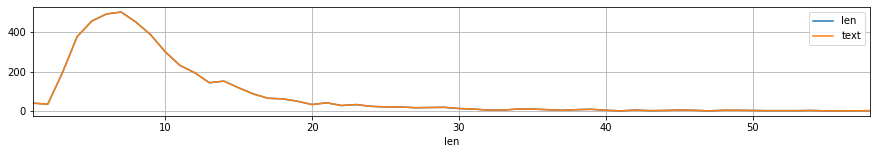

In [81]:
dataset[dataset.len<60].groupby("len")["len","text"].count().plot(figsize=(15,2),grid=True)

## Linguistic Features

In [164]:
import functions
nlp_en = functions.load_spacy_nlp()

In [83]:
# Get one columns with questions
dataset["ques_en"] = dataset[dataset.detected_lang == "en"].question
dataset.loc[dataset.detected_lang == "fr","ques_en"] = dataset[dataset.detected_lang == "fr"].translated_question

In [84]:
dataset["spacy_doc"] = dataset.ques_en.apply(nlp_en)

In [ ]:
dataset = functions.prepare_dependencies(dataset)

In [ ]:
dataset = functions.generate_dep_vectors(dataset)

In [95]:
dependency_counts = pd.DataFrame(dependencies).apply(tuple, axis=1).to_frame(name="Dependency")
dependency_counts["total_freq"] = dataset["dependency_vector"].sum()
dependency_counts.head()

,Dependency,total_freq
0,"(store, dobj, disinfect)",2
1,"(for, prep, info)",1
2,"(more, advmod, put)",1
3,"(a, det, transporter)",1
4,"(-pron-, nsubj, transmit)",3


In [41]:
dataset.tuples.apply(len) == 0

0        True
1        True
2       False
3        True
4       False
        ...  
5049    False
5050    False
5051     True
5052     True
5053     True
Name: tuples, Length: 4757, dtype: bool

In [98]:
# save_dep_graph_html(dataset[dataset.tuples.apply(len) > 0]["spacy_doc"])

In [99]:
dependency_counts[dependency_counts.total_freq>1].sort_values(by="total_freq",ascending=False)["total_freq"][:10]

4626     1903
3874     1431
17290     743
18158     685
6726      678
15323     477
12777     425
14523     346
5336      336
3706      283
Name: total_freq, dtype: int64

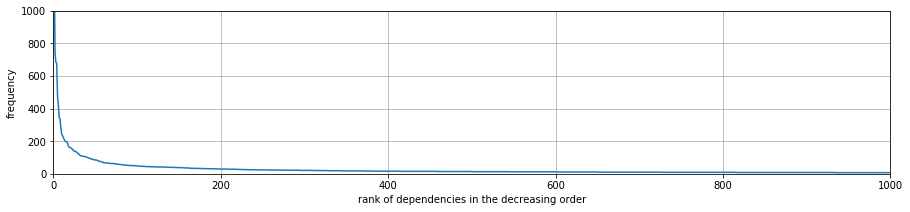

In [100]:
# Frequency of dependencies, (x,y) is y dependencies have x total frequency
ax = dependency_counts[dependency_counts.total_freq>2].sort_values(by="total_freq",ascending=False)["total_freq"].plot(figsize=(15,3), grid=True, use_index=False, xlim=(0,1000), ylim=(0,1000))
ax = ax.set(xlabel="rank of dependencies in the decreasing order", ylabel="frequency")

In [101]:
# Frequency of dependencies, (x,y) is y dependencies have x total frequency
# dependency_counts.sort_values("total_freq",ascending=False).groupby("total_freq")["Dependency"].count().sort_values(ascending=False).plot(figsize=(15,5), grid=True, use_index=False, xticks=range(0,120,5))

In [102]:
# pd.get_dummies(dataset.dependencies.explode()).reset_index().groupby("index").apply(np.sum)
# datatset["tuple_vector"] = pd.get_dummies(dataset.tuples.explode()).reset_index().groupby("index").apply(np.sum).tolist()
# v = vectorized_tuples.set_index("index").loc[5040].rename("vector_val")
# s.explode().reset_index()
# dependencies.combine_first(pd.DataFrame(values,columns=dependencies.columns))
# dataset[dataset["tuples"].apply(lambda x : ("-pron-","do","what","dobj") in x)==True]

## Rules
Note: The order of these rules matters in resolving conflicts

In [165]:
reload(functions)

<module 'functions' from '/home/designer1/Documents/sunanda/DataPerformers/Covid19_collective/CovidFAQs/experiments/functions.py'>

In [320]:
# Dependency based -
if 

dataset.nsubj_dep_lemma.apply(lambda x: if "-PRON-" in x)

0       False
1       False
2        True
3       False
4        True
        ...  
5049     True
5050     True
5051    False
5052     True
5053    False
Name: nsubj_dep_lemma, Length: 4758, dtype: bool

In [117]:
reload(functions)
dataset = functions.apply_token_rules(dataset)

In [118]:
features = dataset.cluster.unique().tolist()

In [119]:
features

['unclassified',
 'covid-precaution-isolation',
 'personal-testing',
 'personal-symptoms',
 'covid-transmission-animals',
 'covid-contagious',
 'covid-symptoms',
 'situation-lockdown',
 'covid-vulnerable',
 'covid-versus',
 'covid-whatif',
 'covid-what',
 'covid-life',
 'situation-future',
 'covid-transmission',
 'situation-stats',
 'covid-precaution-disinfection',
 'personal-testing-location',
 'covid-med',
 'covid-precaution-gear',
 'covid-infection',
 'covid-recovery',
 'covid-incubation',
 'situation-past',
 'covid-transmission-twice']

In [120]:
# Clustering stats
dataset.groupby("cluster")["question"].count()

cluster
covid-contagious                   95
covid-incubation                   28
covid-infection                   111
covid-life                        125
covid-med                         120
covid-precaution-disinfection     106
covid-precaution-gear              86
covid-precaution-isolation        161
covid-recovery                     23
covid-symptoms                    467
covid-transmission                205
covid-transmission-animals         65
covid-transmission-twice           16
covid-versus                       55
covid-vulnerable                   69
covid-what                        151
covid-whatif                      213
personal-symptoms                 357
personal-testing                  191
personal-testing-location          45
situation-future                   41
situation-lockdown                199
situation-past                      4
situation-stats                   185
unclassified                     1638
Name: question, dtype: int64

In [136]:
# Saving the files
path = f"output/Rules+DepVecAHC_{args.suffix}_{args.lang}.csv"
dataset.to_csv(path)
print(f"Rules based output saved to {path}")

Rules based output saved to output/Rules+DepVecAHC_2020-04-21_en.csv


## Dependency based clustering using AHC

In [90]:
# dataset[dataset.cluster == "unclassified"].dependency_vector.to_numpy()

In [92]:
exp_df = dataset[["ques_en","dependencies"]]

In [159]:
nsubj_dep_tokenargs.dep_min_freq = 2
exp_df["dependency_vector"] = list(get_vectors(exp_df.dependencies, dependency_counts[dependency_counts.total_freq>=args.dep_min_freq].Dependency.values.tolist()).toarray())
dataset["dependency_vector"] = list(get_vectors(dataset.dependencies, dependency_counts[dependency_counts.total_freq>=args.dep_min_freq].Dependency.values.tolist()).toarray())

/home/designer1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [137]:
s = [2, 3, 1, 4, 5]
sorted(range(len(s)), key=lambda k: s[k])

[2, 0, 1, 3, 4]

In [139]:
dataset.head()

,timestamp_est,anonymous_id,language,question,detected_lang,translated_question,text,len,ques_en,spacy_doc,...,dependency_vector,tuple_vector,nsubj_lemma,nsubj_token,nsubj_dep_lemma,nsubj_dep_token,root_lemma,root_token,ahc_label,cluster
0,2020-03-18 17:57:10.427,7302144e-abbe-4fa4-aaf1-cf5eb674a862,en,What is Dialogue's position on sick notes?,en,NaN,what is dialogue s position on sick notes,8,What is Dialogue's position on sick notes?,"(What, is, Dialogue, 's, position, on, sick, n...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[be],[is],[position],[position],[be],[is],121,unclassified
1,2020-03-19 11:16:11.354,5a65a4bd-05aa-4ca8-b6da-5f807bde3294,en,What are Dialogue services?,en,NaN,what are dialogue services,4,What are Dialogue services?,"(What, are, Dialogue, services, ?)",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[be],[are],[service],[services],[be],[are],121,unclassified
2,2020-03-19 14:17:16.246,6d60c897-dd96-483d-b528-b65fcae4c1b0,en,Should I practice social distancing?,en,NaN,should i practice social distancing,5,Should I practice social distancing?,"(Should, I, practice, social, distancing, ?)",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[practice],[practice],[-PRON-],[I],[practice],[practice],4,covid-precaution-isolation
3,2020-03-19 14:00:19.88,71a29314-2b32-43d5-b09a-1795a5380e60,fr,LP TEST question,fr,LP TEST question,lp test question,3,LP TEST question,"(LP, TEST, question)",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],[],[],[],[question],[question],4,personal-testing
4,2020-03-19 14:16:05.351,f264fd4b-de03-4dc0-8531-fa9d0a1b0633,en,I'd love to know how long I can be contagious?,en,NaN,i d love to know how long i can be contagious,11,I'd love to know how long I can be contagious?,"(I, 'd, love, to, know, how, long, I, can, be,...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[love, be]","[love, be]",[-PRON-],[I],[love],[love],75,unclassified


In [99]:
args.dist_thresh = 9

X = dataset.dependency_vector.values.tolist()
clustering = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=args.dist_thresh).fit(X)
exp_df["ahc_label"] = clustering.labels_

# Misc.
args.n_clusters = len(exp_df["ahc_label"].unique())
print(f"Found {args.n_clusters} clusters")
exp_df.groupby("ahc_label")["ques_en"].count().sort_values()

Found 188 clusters


/home/designer1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


ahc_label
187      1
115      1
117      1
118      1
119      1
      ... 
22     147
6      176
38     208
121    221
4      732
Name: ques_en, Length: 188, dtype: int64

In [160]:
args.dep_min_freq=10

In [162]:
feats = dependency_counts[dependency_counts.total_freq>=args.dep_min_freq].Dependency.values.tolist()

In [163]:
prominent_dependencies(dataset.dependency_vector, dependency_counts[dependency_counts.total_freq>=args.dep_min_freq].Dependency.values.tolist())

ValueError: arrays must all be same length

In [153]:
cluster_top_deps = pd.DataFrame(dataset.groupby("cluster").dependency_vector.apply(prominent_dependencies, features=feats).to_dict()).T

NameError: name 'feats' is not defined

In [181]:
cluster_top_deps

,0,1,2,3,4,5,6,7,8,9
covid-contagious,"((be, ROOT, be), 67)","((?, punct, be), 53)","((what, attr, be), 33)","((the, det, risk), 33)","((risk, nsubj, be), 30)","((dangerous, acomp, be), 20)","((for, prep, risk), 19)","((of, prep, risk), 18)","((-pron-, nsubj, be), 18)","((pregnant, amod, woman), 11)"
covid-incubation,"((be, ROOT, be), 22)","((?, punct, be), 19)","((incubation, compound, period), 18)","((the, det, period), 17)","((what, attr, be), 16)","((period, nsubj, be), 14)","((time, nsubj, be), 6)","((incubation, compound, time), 6)","((the, det, time), 6)","((the, det, virus), 5)"
covid-infection,"((be, ROOT, be), 31)","((be, auxpass, infect), 29)","((?, punct, be), 29)","((infect, ROOT, infect), 26)","((?, punct, infect), 21)","((-pron-, nsubjpass, infect), 19)","((can, aux, infect), 13)","((get, auxpass, infect), 11)","((how, advmod, long), 10)","((what, attr, be), 10)"
covid-life,"((how, advmod, long), 96)","((the, det, virus), 78)","((stay, ROOT, stay), 50)","((?, punct, stay), 48)","((long, advmod, stay), 45)","((surface, pobj, on), 43)","((virus, nsubj, stay), 40)","((on, prep, stay), 36)","((do, aux, stay), 35)","((survive, ROOT, survive), 33)"
covid-med,"((be, ROOT, be), 45)","((?, punct, be), 37)","((a, det, vaccine), 25)","((cure, ROOT, cure), 15)","((there, expl, be), 14)","((take, ROOT, take), 14)","((?, punct, take), 14)","((treatment, nsubj, be), 13)","((?, punct, cure), 13)","((-pron-, nsubj, take), 12)"
covid-precaution-disinfection,"((hand, dobj, wash), 21)","((to, aux, wash), 21)","((-pron-, poss, hand), 18)","((wash, ROOT, wash), 17)","((-pron-, nsubj, wash), 14)","((?, punct, wash), 13)","((do, aux, have), 12)","((have, ROOT, have), 12)","((-pron-, nsubj, have), 12)","((wash, xcomp, have), 12)"
covid-precaution-gear,"((a, det, mask), 38)","((mask, dobj, wear), 32)","((wear, ROOT, wear), 22)","((?, punct, wear), 18)","((should, aux, wear), 17)","((-pron-, nsubj, wear), 16)","((to, aux, wear), 13)","((be, ROOT, be), 11)","((?, punct, be), 10)","((-pron-, nsubj, have), 9)"
covid-precaution-isolation,"((be, ROOT, be), 16)","((-pron-, nsubj, have), 13)","((have, ROOT, have), 12)","((?, punct, be), 12)","((social, amod, distancing), 11)","((to, aux, isolate), 11)","((-pron-, dobj, isolate), 11)","((?, punct, have), 11)","((how, advmod, long), 11)","((isolate, ROOT, isolate), 8)"
covid-recovery,"((be, ROOT, be), 10)","((from, prep, recover), 9)","((-pron-, nsubj, recover), 7)","((?, punct, be), 7)","((?, punct, take), 6)","((-pron-, nsubj, be), 6)","((take, ROOT, take), 6)","((to, aux, recover), 5)","((how, advmod, long), 5)","((do, aux, take), 5)"
covid-symptoms,"((be, ROOT, be), 356)","((the, det, symptom), 294)","((what, attr, be), 268)","((?, punct, be), 265)","((symptom, nsubj, be), 265)","((of, prep, symptom), 177)","((covid-19, pobj, of), 78)","((a, det, symptom), 51)","((symptom, attr, be), 48)","((covid, pobj, of), 27)"


In [182]:
dataset.head()

,timestamp_est,anonymous_id,language,question,detected_lang,translated_question,text,len,ques_en,spacy_doc,...,dependency_vector,tuple_vector,nsubj_lemma,nsubj_token,nsubj_dep_lemma,nsubj_dep_token,root_lemma,root_token,ahc_label,cluster
0,2020-03-18 17:57:10.427,7302144e-abbe-4fa4-aaf1-cf5eb674a862,en,What is Dialogue's position on sick notes?,en,NaN,what is dialogue s position on sick notes,8,What is Dialogue's position on sick notes?,"(What, is, Dialogue, 's, position, on, sick, n...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[be],[is],[position],[position],[be],[is],121,unclassified
1,2020-03-19 11:16:11.354,5a65a4bd-05aa-4ca8-b6da-5f807bde3294,en,What are Dialogue services?,en,NaN,what are dialogue services,4,What are Dialogue services?,"(What, are, Dialogue, services, ?)",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[be],[are],[service],[services],[be],[are],121,unclassified
2,2020-03-19 14:17:16.246,6d60c897-dd96-483d-b528-b65fcae4c1b0,en,Should I practice social distancing?,en,NaN,should i practice social distancing,5,Should I practice social distancing?,"(Should, I, practice, social, distancing, ?)",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[practice],[practice],[-PRON-],[I],[practice],[practice],4,covid-precaution-isolation
3,2020-03-19 14:00:19.88,71a29314-2b32-43d5-b09a-1795a5380e60,fr,LP TEST question,fr,LP TEST question,lp test question,3,LP TEST question,"(LP, TEST, question)",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],[],[],[],[question],[question],4,personal-testing
4,2020-03-19 14:16:05.351,f264fd4b-de03-4dc0-8531-fa9d0a1b0633,en,I'd love to know how long I can be contagious?,en,NaN,i d love to know how long i can be contagious,11,I'd love to know how long I can be contagious?,"(I, 'd, love, to, know, how, long, I, can, be,...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[love, be]","[love, be]",[-PRON-],[I],[love],[love],75,unclassified


In [142]:
from collections.abc import Iterable   # drop `.abc` with Python 2.7 or lower

def iterable(obj):
    return isinstance(obj, Iterable)

def flatten_series(series):
    # Get all items
    all_items = set(list(series))
    if any([iterable(item) for item in list(series)]):
         all_items = list(set([item for sublist in list(series) for item in sublist]))
    return all_items
            
def get_stats(df, stat_col, groupby_col=None, top_count=3):  
    if groupby_col:
        # dataset.explode("nsubj_lemma").groupby(["cluster","nsubj_lemma"])["nsubj_lemma"].count().rename("count").apply(lambda x: x.nlargest(3,"count"))
        df = df.explode(stat_col).groupby([groupby_col, stat_col])[stat_col].count().rename("count").reset_index()
        # df = df.sort_values(["cluster","count"],ascending=False)
        df = df.groupby(groupby_col).apply(lambda x: x.nlargest(top_count,"count"))
    else:
        df = df.explode(stat_col).groupby(stat_col)[stat_col].count().rename("count").sort_values(ascending=False).reset_index()
   
    return df

In [ ]:
#     df = df.sort_values(["cluster","count"],ascending=False)
df = df.groupby(groupby_col).apply(lambda x: x.nlargest(top_count,"count"))

In [ ]:
df = df.explode(nsubj_dep_token).groupby([groupby_col,stat_col])[stat_col].count().rename("count").reset_index()
#     df = df.sort_values(["cluster","count"],ascending=False)
df = df.groupby(groupby_col).apply(lambda x: x.nlargest(top_count,"count"))

In [136]:
dataset.explode("nsubj_dep_token").groupby("nsubj_dep_token")["nsubj_dep_token"].count().rename("count").sort_values(ascending=False).reset_index()


,nsubj_dep_token,count
0,I,1484
1,it,396
2,symptoms,314
3,we,300
4,virus,242
...,...,...
641,fatigue,1
642,feelings,1
643,feet,1
644,fetus,1


In [148]:
get_stats(dataset,"nsubj_dep_lemma")[:20]

,nsubj_dep_lemma,count
0,-pron-,2309
1,symptom,323
2,virus,243
3,i,148
4,who,122
5,what,96
6,people,86
7,that,73
8,covid-19,73
9,this,57


In [149]:
get_stats(dataset,"nsubj_dep_token")[:20]

,nsubj_dep_token,count
0,i,1605
1,it,415
2,symptoms,314
3,we,308
4,virus,243
5,you,218
6,who,122
7,what,96
8,people,86
9,that,73


In [123]:
get_stats(dataset,"nsubj_dep_token","cluster",5).join(dataset.groupby("cluster")["ques_en"].count()).values

array([['covid-contagious', 'risks', 21, 95],
       ['covid-contagious', 'it', 17, 95],
       ['covid-contagious', 'I', 16, 95],
       ['covid-contagious', 'risk', 14, 95],
       ['covid-contagious', 'virus', 4, 95],
       ['covid-incubation', 'period', 16, 28],
       ['covid-incubation', 'time', 6, 28],
       ['covid-incubation', 'virus', 2, 28],
       ['covid-incubation', 'Covid', 1, 28],
       ['covid-incubation', 'What', 1, 28],
       ['covid-infection', 'I', 35, 111],
       ['covid-infection', 'it', 15, 111],
       ['covid-infection', 'you', 8, 111],
       ['covid-infection', 'i', 5, 111],
       ['covid-infection', 'people', 5, 111],
       ['covid-life', 'virus', 87, 125],
       ['covid-life', 'I', 7, 125],
       ['covid-life', 'coronavirus', 5, 125],
       ['covid-life', 'it', 5, 125],
       ['covid-life', 'Covid', 3, 125],
       ['covid-med', 'I', 18, 120],
       ['covid-med', 'it', 13, 120],
       ['covid-med', 'we', 12, 120],
       ['covid-med', 'vaccine

In [303]:
get_stats(dataset,"root_lemma","cluster",3).join(dataset.groupby("cluster")["ques_en"].count()).values

array([['covid-contagious', 'be', 65],
       ['covid-contagious', 'put', 2],
       ['covid-contagious', 'Be', 1],
       ['covid-incubation', 'be', 22],
       ['covid-incubation', 'detect', 1],
       ['covid-incubation', 'incubate', 1],
       ['covid-infection', 'be', 31],
       ['covid-infection', 'infect', 26],
       ['covid-infection', 'do', 6],
       ['covid-life', 'stay', 50],
       ['covid-life', 'survive', 32],
       ['covid-life', 'live', 20],
       ['covid-med', 'be', 45],
       ['covid-med', 'cure', 15],
       ['covid-med', 'take', 14],
       ['covid-precaution-disinfection', 'wash', 17],
       ['covid-precaution-disinfection', 'have', 12],
       ['covid-precaution-disinfection', 'be', 8],
       ['covid-precaution-gear', 'wear', 22],
       ['covid-precaution-gear', 'be', 11],
       ['covid-precaution-gear', 'have', 8],
       ['covid-precaution-isolation', 'be', 16],
       ['covid-precaution-isolation', 'have', 12],
       ['covid-precaution-isolation', 'i

In [315]:
get_stats(dataset,"dependencies","cluster",10).join(dataset.groupby("cluster")["ques_en"].count()).values.tolist()

[['covid-contagious', ('be', 'ROOT', 'be'), 67, 82],
 ['covid-contagious', ('?', 'punct', 'be'), 53, 82],
 ['covid-contagious', ('the', 'det', 'risk'), 33, 82],
 ['covid-contagious', ('what', 'attr', 'be'), 33, 82],
 ['covid-contagious', ('risk', 'nsubj', 'be'), 30, 82],
 ['covid-contagious', ('dangerous', 'acomp', 'be'), 20, 82],
 ['covid-contagious', ('for', 'prep', 'risk'), 19, 82],
 ['covid-contagious', ('-pron-', 'nsubj', 'be'), 18, 82],
 ['covid-contagious', ('of', 'prep', 'risk'), 18, 82],
 ['covid-contagious', ('pregnant', 'amod', 'woman'), 11, 82],
 ['covid-incubation', ('be', 'ROOT', 'be'), 22, 28],
 ['covid-incubation', ('?', 'punct', 'be'), 19, 28],
 ['covid-incubation', ('incubation', 'compound', 'period'), 18, 28],
 ['covid-incubation', ('the', 'det', 'period'), 17, 28],
 ['covid-incubation', ('what', 'attr', 'be'), 16, 28],
 ['covid-incubation', ('period', 'nsubj', 'be'), 14, 28],
 ['covid-incubation', ('incubation', 'compound', 'time'), 6, 28],
 ['covid-incubation', ('t

In [316]:
# dataset.explode("nsubj_lemma").groupby(["cluster","nsubj_lemma"])["nsubj_lemma"].count().rename("count").apply(lambda x: x.nlargest(3,"count"))

In [220]:
dataset.groupby("cluster")["nsubj_lemma"].apply(get_stats)            

cluster
covid-contagious                 [be, come, be, be, go, be, be, be, be, disinfe...
covid-incubation                 [be, be, be, be, be, be, be, incubate, be, be,...
covid-infection                  [be, do, suspect, infect, be, infect, get, dev...
covid-life                       [live, survive, survive, die, stay, leave, liv...
covid-med                        [do, be, take, take, be, take, overcome, help,...
covid-precaution-disinfection    [go, wash, wash, come, have, have, be, touch, ...
covid-precaution-gear            [need, be, contract, infect, be, wear, have, k...
covid-precaution-isolation       [practice, wonder, be, be, be, isolate, confin...
covid-recovery                   [recover, get, be, recover, be, take, take, ta...
covid-symptoms                   [consult, start, be, be, get, be, be, be, be, ...
covid-transmission               [be, be, start, catch, show, contract, continu...
covid-transmission-animals       [infect, be, transmit, remain, bring, contract

In [ ]:
# For each cluster group df, get the top common dependencies
def overlap_matrix(df, overlap_col, groupby_col):
    get_all = df.groupby(groupby_col)[overlap_col].apply(lambda x: if type(x)==list
    return pd.DataFrame.from_dict({"dep":feats, "count":dependency_vectors.sum()}).sort_values("count",ascending=False).apply(tuple,axis=1).tolist()[:10]

In [159]:
# For each cluster group df, get the top common dependencies
def prominent_dependencies(dependency_vectors, features):
    return pd.DataFrame.from_dict({"dep":features, "count":dependency_vectors.sum()}).sort_values("count",ascending=False).apply(tuple,axis=1).tolist()[:10]

In [100]:
# args.n_clusters=50

# X = dataset.dependency_vector.values.tolist()
# clustering = KMeans(n_clusters=args.n_clusters).fit(X)
# exp_df["kmeans_label"] = clustering.labels_

# # Misc.
# print(f"Found {args.n_clusters} clusters")
# exp_df.groupby("kmeans_label")["ques_en"].count().sort_values()

In [101]:
# for label in exp_df.kmeans_label.unique():
#     print(f"\ncluster #{label}, count - {len(exp_df[exp_df.kmeans_label==label])}")    
#     print ("-------------------------------------------")  
#     print(*exp_df[exp_df.kmeans_label==label][:10].ques_en.tolist(),sep="\n")
#     print ("-------------------------------------------")  

In [102]:
# def col_of_type(df, type):
#     for col in df.columns:
#         if df.
#     return

In [103]:
for label in exp_df.ahc_label.unique():
    print (f"\ncluster #{label}, count - {len(exp_df[exp_df.ahc_label==label])}")    
    print ("-------------------------------------------")  
    print (*exp_df[exp_df.ahc_label==label][:10].ques_en.tolist(),sep="\n")
    print ("-------------------------------------------")  


cluster #121, count - 221
-------------------------------------------
What is Dialogue's position on sick notes?
What are Dialogue services?
What are the criteria that will allow you to lift the state of sanitary emergency and containment instructions?
What are the Quebec statistics?  
What is an Asymptomatic Carrier?
What are the treatments ?
What is the danger for a newborn baby?
What is the% of the population affected by each country in the world?
The incubation time is 14 or 20 days?
What are the types of experimental treatment that could help reduce the inflammation caused by COVID-19?
-------------------------------------------

cluster #4, count - 732
-------------------------------------------
Should I practice social distancing? 
LP TEST question
Hello,
mental health
LP test question
something something this is jared testing
Can you describe the difference between dry cough and oily cough
If you have type 2 diabetes and are treated for hypertension, how much more vulnerable d

How many people are infected in toronto
How many people are infected in Lithuania?
How many people are infected in Quebec  
How many are infected in Brossard?
-------------------------------------------

cluster #23, count - 73
-------------------------------------------
What are the symptoms of covid? 
what are the symptoms of coronavirus
What are the symptoms of the Corina virus? 
What are the symptoms of covid 19?
Is my blood type related to the risk of catching the disease?
Is the severity of disease dependent on incubation period? 
What are the symptoms of the disease?
What are the symptoms of SARS-COV-2
What are the symptoms of covid 
What are the complications of the disease?
-------------------------------------------

cluster #92, count - 43
-------------------------------------------
How long does the virus survive outside the body?
Does the coronavirus survive when an infected person dies?
Does the virus really survive for several hours on asphalt?
How long does the virus su

I live in a densely populated neighborhood and many people from other boroughs have been coming there to shop since the shopping centers closed. I thought it was forbidden to move from one district to another. Which body should I contact: the municipality or the government?
-------------------------------------------

cluster #144, count - 1
-------------------------------------------
My employer has just closed the company, am I eligible for PATT covid-19. - Where is the nearest screening clinic located? - Is my business an essential service? Should I close my company? - How do I make an appointment for covid 19 screening? - What are the symptoms of covid 19? - How can I apply for the PATT covid 19 program. - Does my employer have the right to ask me to return to work. - Does my employer have the right to require me to be tested for covid 19? - Can I report a person who does not respect the isolation measures in case of symptoms of covid 19. - How long are we contagious following the 


cluster #128, count - 1
-------------------------------------------
I have been self isolating for 2 weeks ending Tuesday, I returned to Canada from Florida on the 16th of March. I need a clean bill of health in order to return to work. Does that mean I need to get a covid 19 test?
-------------------------------------------

cluster #95, count - 1
-------------------------------------------
I am infected with HIV, but it is undetectable, I have also had double pneumonia in the past years. I have the pneumonia vaccine, and the flu vaccine. I am currently at work at the SAQ (essential need), I am in contact throughout the day with the people who enter the branch. I take all measures to avoid being reached, but would it be better to withdraw voluntarily so as not to put myself at risk?
-------------------------------------------

cluster #142, count - 1
-------------------------------------------
My partner is type 2 diabetic medicated and very well controlled (54 years old and in good 

In [104]:
if "ahc_label" in exp_df:
    dataset = dataset.drop(columns=["ahc_label"], errors="ignore").join(exp_df["ahc_label"])
if "kmeans_label" in exp_df:
    dataset = dataset.drop(columns=["kmeans_label"], errors="ignore").join(exp_df["kmeans_label"])

In [318]:
dataset.sort_values("ahc_label")

,timestamp_est,anonymous_id,language,question,detected_lang,translated_question,text,len,ques_en,spacy_doc,...,dependency_vector,tuple_vector,nsubj_lemma,nsubj_token,nsubj_dep_lemma,nsubj_dep_token,root_lemma,root_token,ahc_label,cluster
4628,2020-03-31 14:04:33.398,4da5106b-beae-4ea5-b74e-c5053ec1e5fc,en,My husband has had lung cancer which resulted ...,en,NaN,my husband has had lung cancer which resulted ...,39,My husband has had lung cancer which resulted ...,"(My, husband, has, had, lung, cancer, which, r...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[result, go, have]","[had, resulted, go]","[which, -PRON-, husband]","[I, which, husband]",[have],[had],0,too-much-information
1229,2020-03-22 12:58:33.929,211b6c7a-456e-426e-8038-bb9472654b15,fr,"Si je vais dehors et qu’il vente très fort, es...",fr,"If I go outside and it sells very hard, is it ...",if i go outside and it sells very hard is it p...,30,"If I go outside and it sells very hard, is it ...","(If, I, go, outside, and, it, sells, very, har...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[sell, be, go]","[sells, goes, is, go]","[-PRON-, virus]","[I, it, virus]",[be],[is],0,too-much-information
1277,2020-03-22 12:58:34.014,211b6c7a-456e-426e-8038-bb9472654b15,fr,Si je suis allée en massothérapie et que mon t...,fr,If I went to massage therapy and my therapist ...,if i went to massage therapy and my therapist ...,27,If I went to massage therapy and my therapist ...,"(If, I, went, to, massage, therapy, and, my, t...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[have, go, develop, carry, be]","[has, went, is, develop, carrying]","[-PRON-, risk, therapist]","[I, he, risk, therapist]",[be],[is],0,too-much-information
1495,2020-03-22 12:58:33.948,211b6c7a-456e-426e-8038-bb9472654b15,fr,Si je vais donner du sang et que je suis porte...,fr,If I am going to donate blood and I carry the ...,if i am going to donate blood and i carry the ...,27,If I am going to donate blood and I carry the ...,"(If, I, am, going, to, donate, blood, and, I, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[carry, contaminate, go]","[carry, contaminate, going]",[-PRON-],[I],"[team, contaminate]","[team, contaminate]",0,too-much-information
2400,2020-03-23 16:55:40.392,85e7cc80-701e-46e3-9193-c3d74c1987eb,en,Isn't the economy impact (and the panic reacti...,en,NaN,is n t the economy impact and the panic reacti...,32,Isn't the economy impact (and the panic reacti...,"(Is, n't, the, economy, impact, (, and, the, p...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[lose, kill, seem]","[lose, seems, kills]","[-PRON-, %, virus]","[%, virus, It]","[seem, be]","[Is, seems]",0,too-much-information
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2197,2020-03-23 08:42:50.62,5aba2275-7f75-4532-9a7f-88e683ff14ab,fr,Est-ce qu'on peut guérir du coronavirus ?,fr,Can we cure coronavirus?,can we cure coronavirus,4,Can we cure coronavirus?,"(Can, we, cure, coronavirus, ?)",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[cure],[cure],[-PRON-],[we],[cure],[cure],185,covid-med
4800,2020-04-04 08:52:32.469,3f557b79-4723-4722-9632-a86c849a525d,fr,Le covid-19 se guérit-il?,fr,Can covid-19 be cured?,can covid be cured,4,Can covid-19 be cured?,"(Can, covid-19, be, cured, ?)",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],[],[],[],[cure],[cured],185,covid-med
2840,2020-03-23 19:21:41.178,d2bd59c3-6224-4d86-8247-d7a09ec1d003,fr,Comment guérir?,fr,How to cure?,how to cure,3,How to cure?,"(How, to, cure, ?)",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [106]:
# path = f"output/DependencyVectorClustered_{args.n_clusters}c{args.dep_min_freq}mf{args.dist_thresh}dt_{args.suffix}.csv"
# dataset.to_csv(path)
# print(f"AHC on top of Dependency Vector output saved to {path}")

In [317]:
get_stats(dataset,"dependencies","ahc_label",10).join(dataset.groupby("ahc_label")["ques_en"].count()).values.tolist()

[[0, ('the', 'det', 'virus'), 7, 5],
 [0, ('-pron-', 'nsubj', 'go'), 5, 5],
 [0, ('?', 'punct', 'be'), 3, 5],
 [0, ('and', 'cc', 'go'), 3, 5],
 [0, ('be', 'ROOT', 'be'), 3, 5],
 [0, ('if', 'mark', 'go'), 3, 5],
 [0, (',', 'punct', 'be'), 2, 5],
 [0, ('carry', 'conj', 'go'), 2, 5],
 [0, ('go', 'advcl', 'be'), 2, 5],
 [0, ('to', 'prep', 'go'), 2, 5],
 [1, ('take', 'ROOT', 'take'), 76, 79],
 [1, ('?', 'punct', 'take'), 61, 79],
 [1, ('-pron-', 'nsubj', 'take'), 57, 79],
 [1, ('can', 'aux', 'take'), 30, 79],
 [1, ('should', 'aux', 'take'), 22, 79],
 [1, ('test', 'dobj', 'take'), 12, 79],
 [1, (',', 'punct', 'take'), 11, 79],
 [1, ('-pron-', 'nsubj', 'have'), 11, 79],
 [1, ('the', 'det', 'test'), 10, 79],
 [1, ('have', 'advcl', 'take'), 7, 79],
 [2, ('end', 'ROOT', 'end'), 17, 18],
 [2, ('will', 'aux', 'end'), 15, 18],
 [2, ('?', 'punct', 'end'), 13, 18],
 [2, ('when', 'advmod', 'end'), 13, 18],
 [2, ('the', 'det', 'end'), 8, 18],
 [2, ('pandemic', 'amod', 'end'), 6, 18],
 [2, ('-pron-', 'n

## Analysing dependencies

In [182]:
dependency_counts = dependency_counts.join(pd.DataFrame(dataset.groupby("cluster").dependency_vector.apply(sum).apply(pd.Series)).T)

In [ ]:
dependency_counts.head()

In [191]:
def get_cat_freq(row):
    return sum([1 for val in row if val>0])

In [196]:
dependency_counts["cat_freq"] = dependency_counts[features].apply(get_cat_freq,axis=1)

In [349]:
# dependency_counts.sort_values("cat_freq",ascending=False).groupby("cat_freq").count()

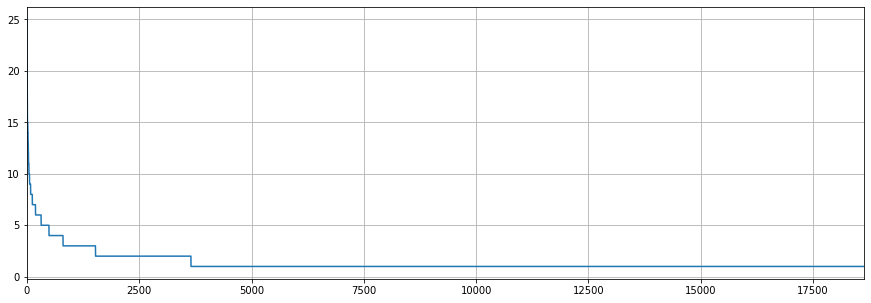

In [354]:
# Category Frequency of Dependencies, (x,y) is y dependencies have appeared in x distinct categories
dependency_counts.sort_values(by="cat_freq",ascending=False)["cat_freq"].plot(figsize=(15,5),grid=True, use_index=False)

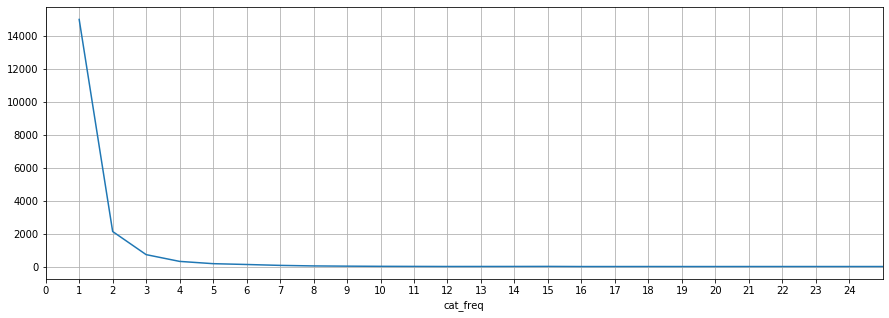

In [254]:
# Category Frequency of Dependencies, (x,y) is y dependencies have appeared in x distinct categories
dependency_counts.groupby("cat_freq").count()["Dependency"].plot(figsize=(15,5),grid=True, xticks=range(0,25,1))

In [267]:
# later - Drop the stopword like dependencies, as in the ones which appear
# Keeping the stopword dependencies for now, since I want to see them all, before discarding carelessly
dependency_counts[dependency_counts.cat_freq > 20]

,Dependency,covid-contagious,covid-incubation,covid-infection,covid-life,covid-med,covid-precaution-disinfection,covid-precaution-gear,covid-precaution-isolation,covid-recovery,...,personal-testing,personal-testing-location,situation-future,situation-lockdown,situation-past,situation-stats,too-much-information,unclassified,cat_freq,total_freq
1840,"(?, punct, be)",53,19,29,2,36,6,10,12,6,...,33,1,4,18,0,59,202,409,25,1432
2758,"(-pron-, nsubj, be)",18,0,9,2,5,3,7,7,5,...,9,0,1,16,0,3,272,190,21,682
3671,"(the, det, virus)",9,5,4,78,2,1,5,0,4,...,5,0,0,4,0,10,97,120,21,476
16707,"(be, ROOT, be)",67,22,31,2,43,8,11,16,9,...,39,1,5,31,0,75,325,521,25,1906



unclassified [1490]
-------------------

                      Dependency  unclassified
16707             (be, ROOT, be)           521
1840              (?, punct, be)           409
2758         (-pron-, nsubj, be)           190
13185           (what, attr, be)           122
3671           (the, det, virus)           120
...                          ...           ...
9360           (be, aux, travel)             2
6764           (same, acomp, be)             2
3583           (what, det, kind)             2
636        (between, prep, link)             2
11097  (temperature, dobj, take)             2

[1430 rows x 2 columns]

covid-precaution-isolation [0089]
---------------------------------

                       Dependency  covid-precaution-isolation
16707              (be, ROOT, be)                          16
12871       (-pron-, nsubj, have)                          12
1840               (?, punct, be)                          12
12748         (how, advmod, long)                  

/home/designer1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/designer1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


                  Dependency  covid-symptoms
16707         (be, ROOT, be)             356
4734     (the, det, symptom)             294
13185       (what, attr, be)             268
1696    (symptom, nsubj, be)             265
1840          (?, punct, be)             265
...                      ...             ...
6023       (if, mark, start)               2
8123       (and, cc, throat)               2
636    (between, prep, link)               2
2348       (for, prep, last)               2
17945        (one, attr, be)               2

[208 rows x 2 columns]

situation-lockdown [0162]
-------------------------

                    Dependency  situation-lockdown
16176           (go, ROOT, go)                  91
3757       (-pron-, nsubj, go)                  86
6382            (?, punct, go)                  84
7285            (can, aux, go)                  51
8199            (to, prep, go)                  49
...                        ...                 ...
18005       (street, pobj

                       Dependency  covid-transmission
3671            (the, det, virus)                  54
16707              (be, ROOT, be)                  46
1840               (?, punct, be)                  39
9920       (spread, ROOT, spread)                  31
15021  (transmit, ROOT, transmit)                  30
...                           ...                 ...
8085          (-pron-, nsubj, do)                   2
16122        (can, aux, minimize)                   2
4940            (there, expl, be)                   2
18554            (what, dobj, do)                   2
1645   (transmissible, acomp, be)                   2

[163 rows x 2 columns]

personal-testing-location [0043]
--------------------------------

                      Dependency  personal-testing-location
2719        (get, auxpass, test)                         30
11396      (where, advmod, test)                         28
16105         (test, ROOT, test)                         26
2409            (can

                         Dependency  covid-transmission-twice
4388         (-pron-, nsubj, catch)                         9
4862              (can, aux, catch)                         8
13283          (catch, ROOT, catch)                         8
5567         (again, advmod, catch)                         6
173           (-pron-, dobj, catch)                         6
9074              (?, punct, catch)                         6
1840                 (?, punct, be)                         4
16707                (be, ROOT, be)                         4
2758            (-pron-, nsubj, be)                         4
12311             (,, punct, catch)                         3
7248          (possible, acomp, be)                         3
3671              (the, det, virus)                         3
2935     (contract, ROOT, contract)                         2
11917          (can, aux, contract)                         2
105                (to, aux, catch)                         2
10752   

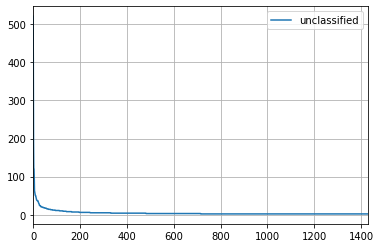

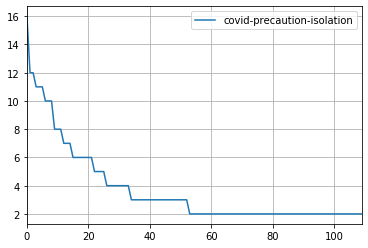

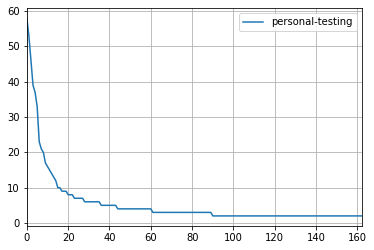

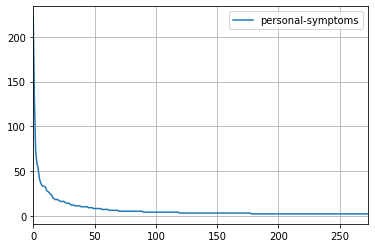

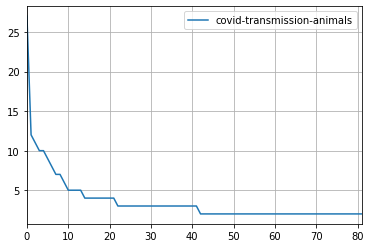

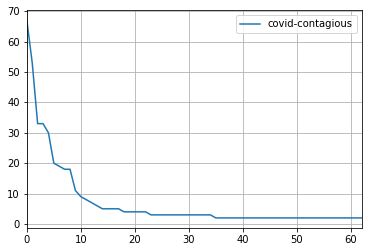

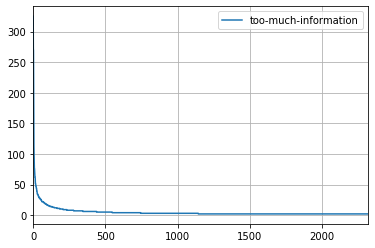

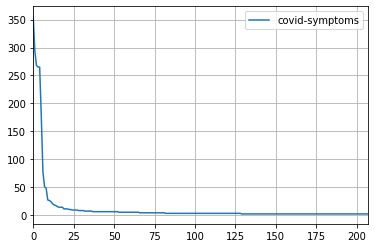

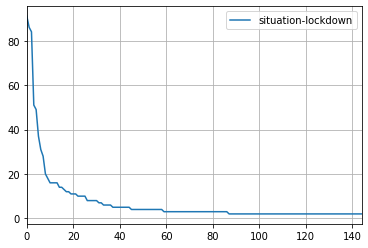

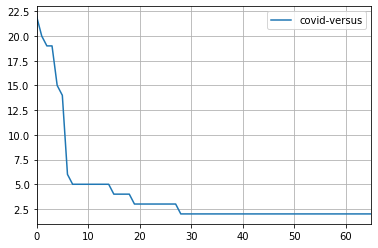

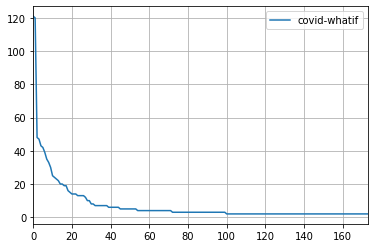

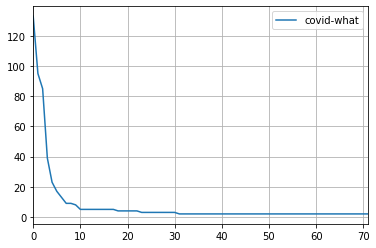

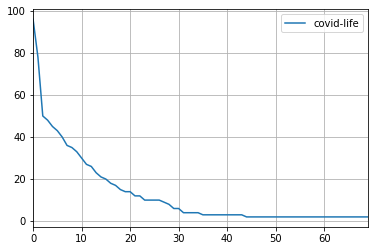

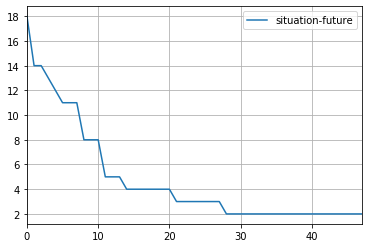

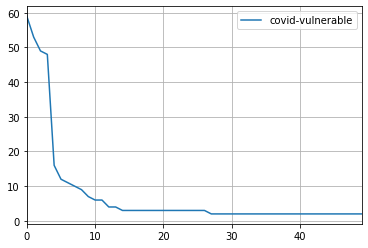

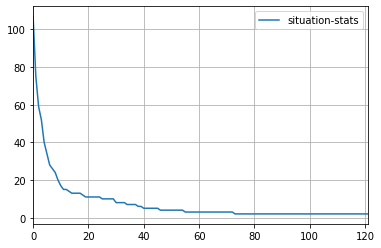

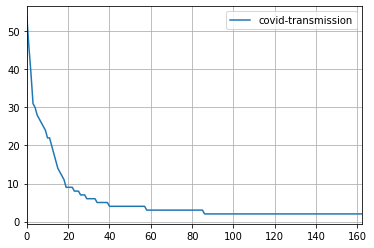

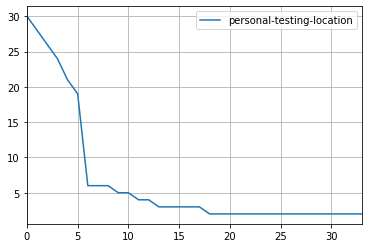

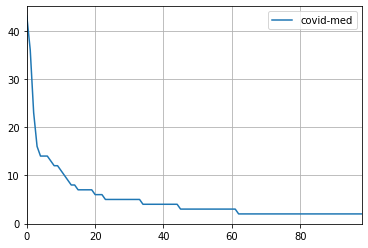

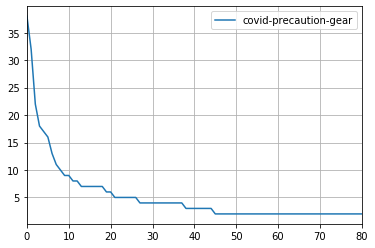

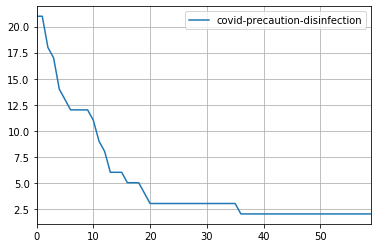

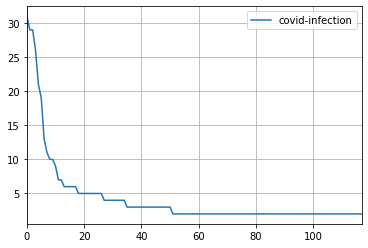

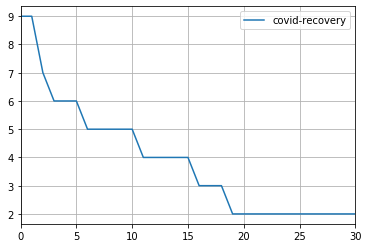

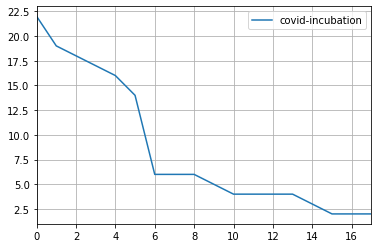

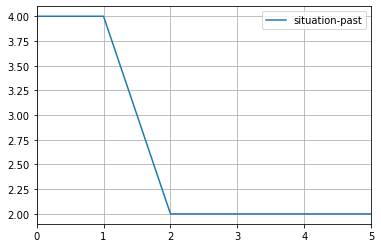

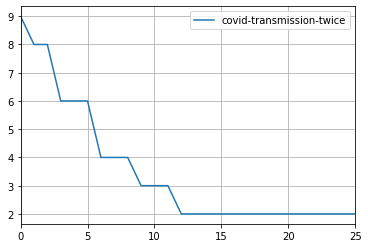

In [303]:
for feature in features:
    print(f"\n{feature} [{len(dataset[dataset.cluster == feature]):04}]\n{'-'*len(feature)}-------\n")
    dependency_counts[["Dependency",feature]].sort_values(by=feature, ascending=False)[dependency_counts[feature]>1].plot(use_index=False, grid=True)
    print(dependency_counts[["Dependency",feature]].sort_values(by=feature, ascending=False)[dependency_counts[feature]>1])

## LSA and AHC

In [ ]:
'''
    If considering NLTK tokenization of questions
'''
# Combining french translations and english questions in one column
eng = dataset[dataset.detected_lang == "en"].question.to_frame(name="text")
french = dataset[dataset.detected_lang == "fr"].translated_question.to_frame(name="text")
d = eng.combine_first(french).dropna()

# Adding cluster information from rules
d["cluster"] = dataset.cluster

# Adding length as a feature
# d["len"] = dataset.len

# Selecting unclassified questions
d = d[d.cluster=="unclassified"] # May be also cluster too-much-information clusters

# Pre-processing
import nltk

stopwords_list = nltk.corpus.stopwords.words('english')
wn_lemmatizer = nltk.stem.WordNetLemmatizer()

def bulk_tokenizer(texts):
#      return [[wn_lemmatizer.lemmatize(token) for token in nltk.word_tokenize(text)] for text in texts]
     return [nltk.word_tokenize(text) for text in texts]

In [ ]:
'''
    If considering the same preprocessing as used for rules above
'''
d = dataset[dataset.cluster=="unclassified"][["text","cluster","question","translated_question"]]

def bulk_tokenizer(texts):
     return [text.split() for text in texts]

In [ ]:
d.head()

In [ ]:
args.n_topics = 15
args.dist_thresh = 0.8
model = utils.text.representation.LSI(args, tokenizer=bulk_tokenizer)
d["embedding"] = model.generate_embedding(d.text, returnarray=False)

lsa_features = pd.DataFrame(d["embedding"].values.tolist(), index= d.index).to_numpy()

use_len = False
if use_len:
    # Add len to the feature vector
    d[["embedding","len"]].apply(lambda x: x.embedding.append(x.len), axis=1)

    from sklearn import preprocessing

    x = d.embedding.tolist() #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    lsa_features = x_scaled
    
# Cluster
X = lsa_features
clustering = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=args.dist_thresh).fit(X)
d["ahc_label"] = clustering.labels_

# Misc.
args.n_clusters = len(d["ahc_label"].unique())
print(f"Found {args.n_clusters} clusters")
d.groupby("ahc_label")["question"].count().sort_values()

In [ ]:
d.groupby("ahc_label")["text"].count().describe()

In [ ]:
d.text[d.text.str.contains("what should i do",case=False)]

In [ ]:
import spacy
from spacy import displacy

# Load English tokenizer, tagger, parser, NER and word vectors
nlp_en = spacy.load("en_core_web_sm")
nlp_fr = spacy.load("fr_core_news_md")

In [ ]:
# for label in d.ahc_label.unique():
for label in d.ahc_label.unique():
    if len(d[d.ahc_label==label]) < 10:
        print(f"\ncluster #{label}, count - {len(d[d.ahc_label==label])}")
        print ("-------------------------------------------")  
        docs = d[d.ahc_label==label].text.tolist()
        print(*docs,sep="\n")
        print ("-------------------------------------------")  
            
        
        for doc in docs:
            if type(doc) == str:
                doc = nlp_en(doc)
                print (doc)
                print ("-------------------------------------------")      
                displacy.render(doc, style='dep')
                for sentence in doc.sents:
#                     for root_child in sentence.root.children:
#                         if root_child.dep_ in ["advmod","aux"]:
#                             tuples.append([token.head.lemma_, root_child.lemma_])    
                    tuples = []
                    for token in sentence:
                        if "nsubj" in token.dep_:      
                            tuples.append([token.lemma_, token.head.lemma_])                
                            for sibling in token.head.children:
                                if sibling.dep_ in ["dobj","acomp"]:
                                    tuples.append([token.lemma_, token.head.lemma_, sibling.lemma_])  
                    for svo in tuples:
                        print(*svo,sep=" --> ") 
    #                         print([child.text for child in token.head.children])
        #                 print ( token.head.text, token.head.lemma_, token.head.tag_, token.head.i, token.dep_, token.i, token.text, token.lemma_, token.tag_, sep="\t")  
                print ("-------------------------------------------")


In [ ]:
dataset = dataset.drop(columns=["ahc_label"], errors="ignore").join(d["ahc_label"])

In [ ]:
path = f"output/simpleLsa_{args.n_topics}n{args.dist_thresh}dt_{args.suffix}.csv"
dataset.drop(features, axis="columns", errors="ignore").drop(["total"], axis="columns", errors="ignore").to_csv(path)
print(f"AHC on top of rule based output saved to {path}")

## LSA and AHC - 2nd Time

In [ ]:
path = f"output/simpleLsa_{args.n_topics}n{args.dist_thresh}dt_{args.suffix}_{args.lang}_checked.csv"
print(path)

In [ ]:
d = pd.read_csv(path, index_col=0)

In [ ]:
d = d[["question","text", "translation", "cluster", "tags", "ahc_label", "cluster_count"]]

In [ ]:
d.head()

In [ ]:
d = create_rules_based_clusters(d, cluster_col="cluster_2")

In [ ]:
d.head()

In [ ]:
# import nltk
# stopwords_list = nltk.corpus.stopwords.words('english')
# wn_lemmatizer = nltk.stem.WordNetLemmatizer()

In [ ]:
def bulk_tokenizer(texts):
#      return [[wn_lemmatizer.lemmatize(token) for token in nltk.word_tokenize(text)] for text in texts]
     return [text.split() for text in texts]

In [ ]:
args.n_topics = 15
args.dist_thresh = 0.8
model = utils.text.representation.LSI(args, tokenizer=bulk_tokenizer)
d["embedding"] = model.generate_embedding(d.text, returnarray=False)

# Cluster
X = pd.DataFrame(d["embedding"].values.tolist(), index= d.index).to_numpy()
clustering = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=args.dist_thresh).fit(X)
d["ahc_label"] = clustering.labels_

# Misc.
args.n_clusters = len(d["ahc_label"].unique())
print(f"Found {args.n_clusters} clusters")
d.groupby("ahc_label")["text"].count().sort_values()

In [ ]:
d.groupby("ahc_label")["text"].count().describe()

In [ ]:
# To Translated
# print(*d.text.tolist(),sep="\n")

In [ ]:
for label in d.ahc_label.unique():
    print(f"\ncluster #{label}, count - {len(d[d.ahc_label==label])}")
    print(*zip(d[d.ahc_label==label][:10].question.tolist(),d[d.ahc_label==label][:10].text.tolist()),sep="\n")

In [ ]:
dataset.head()

In [ ]:
dataset = dataset.drop(features, axis="columns").drop("total", axis="columns").join(d["ahc_label"])

In [ ]:
dataset.head()

In [ ]:
# print(*dataset.question.tolist(),sep="\n")

In [ ]:
path = f"output/simpleLsa_{args.n_topics}n{args.dist_thresh}dt_{args.suffix}_{args.lang}.csv"
dataset.to_csv(path)
print(f"AHC on top of rule based output saved to {path}")

## Iterative Clustering